### Download dependencies

In [1]:
# Note: Must install kaggle first:
#       Download .tar.gz file from Pypi
#       Unzip compressed file
#       Run setup using `python -m setup.py install`

# Install additional packages
!pip install opendatasets --upgrade --quiet

### Downloading the data

Download the data package from Kaggle to a temporary directory; the temp dir is created via `tempfile` and the dataset download is handled via `opendatasets`. Note Kaggle asks for a username and key -- type "a" into both.

In [2]:
import os
import tempfile
import opendatasets as od

# Create new temporary directory
data_folder = tempfile.mkdtemp()

# Download dataset into temporary directory
# A more complete dataset can be found at 'https://www.kaggle.com/datasets/patrickzel/flight-delay-and-cancellation-dataset-2019-2023'
dataset = 'https://www.kaggle.com/datasets/usdot/flight-delays'
od.download(dataset, data_folder, force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  a


Your Kaggle Key:

  ········


Dataset URL: https://www.kaggle.com/datasets/usdot/flight-delays


100%|███████████████████████████████████████████████████████████████████████████████| 191M/191M [00:06<00:00, 29.8MB/s]


### Data element insights

The following categories are given in xx:yy - hour:minute format (e.g. 1536 means 3:36pm, 345 means 3:45am, 16 means 00:16am): 
- `SCHEDULED_DEPARTURE`
- `DEPARTURE_TIME`
- `SCHEDULED_ARRIVAL`
- `ARRIVAL_TIME`
- `WHEELS_OFF`
- `WHEELS_ON`

Other parameters are given in minutes (negative values indicate the actual time occurred before the scheduled time by the same magnitude):
- `ARRIVAL_DELAY`
- `DEPARTURE_DELAY`
- `TAXI_IN`
- `TAXI_OUT`
- `SCHEDULED_TIME`
- `ELAPSED_TIME`
- `AIR_TIME`

The `DISTANCE` parameter is given in miles.

Specific definitions of some parameters are as follows:
- `WHEELS_OFF`: The time point that the aircraft's wheels leave the ground.
- `WHEELS_ON`: The time point that the aircraft's wheels touch on the ground.
- `TAXI_OUT`: The time duration elapsed between departure from the origin airport gate and wheels off.
- `TAXI_IN`: The time duration elapsed between wheels-on and gate arrival at the destination airport.
- `AIR_TIME`: The time duration between wheels_off and wheels_on time.

And, similarly, relationships between different data columns can be defined:
- `ARRIVAL_TIME` = `WHEELS_ON` + `TAXI_IN`
- `ARRIVAL_DELAY` = `ARRIVAL_TIME` - `SCHEDULED_ARRIVAL`
- `DEPARTURE_TIME` = `WHEELS_OFF` - `TAXI_OUT`
- `DEPARTURE_DELAY` = `DEPARTURE_TIME` - `SCHEDULED_DEPARTURE`
- `ELAPSED_TIME` = `AIR_TIME` + `TAXI_IN` + `TAXI_OUT`
- `AIR_TIME` = `WHEELS_ON` - `WHEELS_OFF`

### Airlines dataset

Let's look at the Airlines dataframe. In structure, it's pretty straight-forward, comprising two columns: the International Air Transport Association (IATA) code for each airline, and the name of the respective airline.

In [3]:
import pandas as pd

# Read each CSV dataset
airlines_path = os.path.join(data_folder,'flight-delays','airlines.csv')

# Read each CSV into Pandas dataframe
airlines = pd.read_csv(airlines_path,low_memory=False)

print(airlines.head())

  IATA_CODE                 AIRLINE
0        UA   United Air Lines Inc.
1        AA  American Airlines Inc.
2        US         US Airways Inc.
3        F9  Frontier Airlines Inc.
4        B6         JetBlue Airways


### Airports dataset

We need information on which airports the airlines operate from and where each airport is located. Each airport has an associated IATA code.

In [4]:
# Read each CSV dataset
airports_path = os.path.join(data_folder,'flight-delays','airports.csv')

# Read each CSV into Pandas dataframe
airports = pd.read_csv(airports_path,low_memory=False)

print(airports.head())

  IATA_CODE                              AIRPORT         CITY STATE COUNTRY  \
0       ABE  Lehigh Valley International Airport    Allentown    PA     USA   
1       ABI             Abilene Regional Airport      Abilene    TX     USA   
2       ABQ    Albuquerque International Sunport  Albuquerque    NM     USA   
3       ABR            Aberdeen Regional Airport     Aberdeen    SD     USA   
4       ABY   Southwest Georgia Regional Airport       Albany    GA     USA   

   LATITUDE  LONGITUDE  
0  40.65236  -75.44040  
1  32.41132  -99.68190  
2  35.04022 -106.60919  
3  45.44906  -98.42183  
4  31.53552  -84.19447  


### Flights dataset

The remaining file contains data for each flight described by the date of each flight, flight specifics (tail number, airline, and flight number), and the flight's origin and destination information. The data also include flight diversion, delay, and cancellation status. If the flights were delayed, the dataset provides the delay type and delay length. Note that January 1, 2015 (`MONTH`=1, `DAY`=1, `YEAR`=2015) was a Thursday; thus the first day of the week (`DAY_OF_WEEK`=1) corresponds to Monday.

In [5]:
# Read each CSV dataset
flights_path = os.path.join(data_folder,'flight-delays','flights.csv')

# Read each CSV into Pandas dataframe
flights = pd.read_csv(flights_path,low_memory=False)
pd.set_option('display.max_columns', None)
print(flights.head())

   YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      1    1            4      AS             98      N407AS   
1  2015      1    1            4      AA           2336      N3KUAA   
2  2015      1    1            4      US            840      N171US   
3  2015      1    1            4      AA            258      N3HYAA   
4  2015      1    1            4      AS            135      N527AS   

  ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  DEPARTURE_TIME  \
0            ANC                 SEA                    5          2354.0   
1            LAX                 PBI                   10             2.0   
2            SFO                 CLT                   20            18.0   
3            LAX                 MIA                   20            15.0   
4            SEA                 ANC                   25            24.0   

   DEPARTURE_DELAY  TAXI_OUT  WHEELS_OFF  SCHEDULED_TIME  ELAPSED_TIME  \
0            -11.0      21.0        

### Split data: Cancelled VS Non-cancelled ("successful")
We'll start by splitting all recorded flights into cancelled flights and non-cancelled (or 'successful') flights, only focusing on the latter throughout the remainder of the tutorial.

In [6]:
# Split dataset into cancelled flights and uncancelled flights
flown_flights = flights[flights['CANCELLED']==0]
cancl_flights = flights[flights['CANCELLED']==1]

### Cleaning / homogenizing flight data
We'll then simply the resulting dataframe further:

- Successful flights were not cancelled, so we'll remove the `CANCELLED` and `CANCELLATION_REASON` columns.
- `TAIL_NUMBER` and `FLIGHT_NUMBER` will not impact the delay type, so we'll get rid of those.
- `ARRIVAL_DELAY` accounts for `ARRIVAL_TIME` and `SCHEDULED_ARRIVAL`, so keep the former and remove the latter.
- `ARRIVAL_TIME` accounts for `WHEELS_ON` and `TAXI_IN`, so keep the former and remove the latter.
- `DEPARTURE_DELAY` accounts for `DEPARTURE_TIME` and `SCHEDULED_DEPARTURE`; keep the former, remove the latter.
- `DEPARTURE_TIME` accounts for `WHEELS_OFF`, and `TAXI_OUT`; keep the former, remove the latter.
- `ELAPSED_TIME` accounts for `AIR_TIME` and `DISTANCE` since longer distances require longer air time. Keep the former, remove the latter.
- `ARRIVAL_DELAY` is likely the sum of the other delay types (`DEPARTURE`,`AIR_SYSTEM`,`SECURITY`,`LATE_AIRCRAFT`, and `WEATHER`) but we cannot be sure. Remove `ARRIVAL_DELAY` and define a new column to represent the delay sum.
- Rearrange all columns to group `_DELAY` types .

Coincidentally, dropping these eight columns also eliminates every column of a format other than minutes or miles.

In [7]:
# Remove cancellation-related columns
clean_flown = flown_flights.drop(columns=['CANCELLED','CANCELLATION_REASON'])

# Remove irrelevant flight information (tail, flight number)
clean_flights = clean_flown.drop(columns=['TAIL_NUMBER','FLIGHT_NUMBER'])

# Remove redundant arrival data
clean_arrival = clean_flights.drop(columns=['ARRIVAL_TIME','SCHEDULED_ARRIVAL','WHEELS_ON','TAXI_IN'])

# Remove redundant departure data
clean_departure = clean_arrival.drop(columns=['DEPARTURE_TIME','SCHEDULED_DEPARTURE','WHEELS_OFF','TAXI_OUT'])

# Remove redundant delay summation data
clean_arrival = clean_departure.drop(columns=['ARRIVAL_DELAY','AIR_TIME','DISTANCE'])

# Calculate the total delay for each flight
clean_arrival['TOTAL_DELAY'] = clean_arrival['DEPARTURE_DELAY'] + clean_arrival['AIR_SYSTEM_DELAY'] + clean_arrival['SECURITY_DELAY'] + clean_arrival['AIRLINE_DELAY'] + clean_arrival['LATE_AIRCRAFT_DELAY'] + clean_arrival['WEATHER_DELAY']

# Rearrange columns to group similar concepts
clean_arrival = clean_arrival[['YEAR','MONTH','DAY','DAY_OF_WEEK','AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT',
                               'SCHEDULED_TIME','ELAPSED_TIME','DIVERTED', 'DEPARTURE_DELAY','AIR_SYSTEM_DELAY',
                               'SECURITY_DELAY','AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY','WEATHER_DELAY','TOTAL_DELAY']]

# Show current dataframe
clean_arrival.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_TIME,ELAPSED_TIME,DIVERTED,DEPARTURE_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,TOTAL_DELAY
0,2015,1,1,4,AS,ANC,SEA,205.0,194.0,0,-11.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,LAX,PBI,280.0,279.0,0,-8.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,SFO,CLT,286.0,293.0,0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,LAX,MIA,285.0,281.0,0,-5.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,SEA,ANC,235.0,215.0,0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN


### Handling date/time

Parameters like `YEAR`, `MONTH`, and `DAY` can be combined into a single parameter `DAY_OF_YEAR`, which has the added benefit of tracking seasonality and possibly interesting metrics later on.

In [8]:
from datetime import datetime

# Combine YEAR, MONTH, and DAY into a single column
clean_arrival['DAY_OF_YEAR'] = [datetime(y,m,d).timetuple().tm_yday for y,m,d in zip(clean_arrival['YEAR'],
                                                                                     clean_arrival['MONTH'],
                                                                                     clean_arrival['DAY'])]
# Consolidate calendar information
clean_doy = clean_arrival.drop(columns=['YEAR','MONTH','DAY'])

# Print output metrics
print('\n# rows:', clean_doy.shape[0], '\n# categories:',clean_doy.shape[1])
print('\n',clean_doy.head())


# rows: 5729195 
# categories: 15

    DAY_OF_WEEK AIRLINE ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_TIME  \
0            4      AS            ANC                 SEA           205.0   
1            4      AA            LAX                 PBI           280.0   
2            4      US            SFO                 CLT           286.0   
3            4      AA            LAX                 MIA           285.0   
4            4      AS            SEA                 ANC           235.0   

   ELAPSED_TIME  DIVERTED  DEPARTURE_DELAY  AIR_SYSTEM_DELAY  SECURITY_DELAY  \
0         194.0         0            -11.0               NaN             NaN   
1         279.0         0             -8.0               NaN             NaN   
2         293.0         0             -2.0               NaN             NaN   
3         281.0         0             -5.0               NaN             NaN   
4         215.0         0             -1.0               NaN             NaN   

   AIRLINE_DELAY  L

### Airline consistency

We still need to handle airline specification. Currently, airlines are specified by uninterpretable 2-letter acronyms (ex. "NK"). We'll bring in other datasets to convert the acronyms to human-readable labels (ex. 'Spirit Airlines').

In [9]:
# Generate dictionaries from dataframes
airline_dict = dict(zip(airlines.IATA_CODE, airlines.AIRLINE))

# Update airline name
airline_name = []
[airline_name.append(airline_dict[u]) for u in clean_doy['AIRLINE']]
clean_doy['AIRLINE'] = airline_name

print(clean_doy.head())

   DAY_OF_WEEK                 AIRLINE ORIGIN_AIRPORT DESTINATION_AIRPORT  \
0            4    Alaska Airlines Inc.            ANC                 SEA   
1            4  American Airlines Inc.            LAX                 PBI   
2            4         US Airways Inc.            SFO                 CLT   
3            4  American Airlines Inc.            LAX                 MIA   
4            4    Alaska Airlines Inc.            SEA                 ANC   

   SCHEDULED_TIME  ELAPSED_TIME  DIVERTED  DEPARTURE_DELAY  AIR_SYSTEM_DELAY  \
0           205.0         194.0         0            -11.0               NaN   
1           280.0         279.0         0             -8.0               NaN   
2           286.0         293.0         0             -2.0               NaN   
3           285.0         281.0         0             -5.0               NaN   
4           235.0         215.0         0             -1.0               NaN   

   SECURITY_DELAY  AIRLINE_DELAY  LATE_AIRCRAFT_DELAY  W

### Origin / Destination inconsistencies

At this point, airport identifiers are still problematic. For example, `ORIGIN_AIRPORT` and `DESTINATION_AIRPORT` both contain 3-letter IATA airport codes (ex. "LAX") and 5-digit FAA numerical codes (ex. 12789). Both formats are valid, but their formats are inconsistent.

The numerical FAA airport identifiers are not included in the original Kaggle dataset, but they can be connected using two additional datafiles provided by the Bureau of Transportation Statistics (`L_AIRPORT_ID.csv` and `L_AIRPORT.csv`). The first links the numerical ID value to an aiport name, and the second links the airport name to its alphabetic airport identifier.

In [10]:
# Define paths for files connecting airport IDs and IATA codes
id_path = os.path.join(os.getcwd(),'flight-delays','L_AIRPORT_ID.csv')
code_path = os.path.join(os.getcwd(),'flight-delays','L_AIRPORT.csv')

# Read CSV files as dataframes
airport_id = pd.read_csv(id_path, low_memory=False)
airport_code = pd.read_csv(code_path, low_memory=False)

# Merge dataframes on Airport name
merged_codes = pd.merge(airport_id, airport_code, on="Description")

# Rename dataframe columns
merged_codes = merged_codes.rename(columns={"Code_x": "FAA_ID", "Code_y": "IATA"})

# Show new results
merged_codes.head()

,FAA_ID,Description,IATA
0,10001,"Afognak Lake, AK: Afognak Lake Airport",01A
1,10003,"Granite Mountain, AK: Bear Creek Mining Strip",03A
2,10004,"Lik, AK: Lik Mining Camp",04A
3,10005,"Little Squaw, AK: Little Squaw Airport",05A
4,10006,"Kizhuyak, AK: Kizhuyak Bay",06A


With this "Rosetta stone" in hand, we correct the `flights` dataset to contain only IATA codes in both columns. 

In [11]:
print('\nOld airport origin list:\n', clean_doy.ORIGIN_AIRPORT.unique())

# Create dictionary linking airport IDs with IATA codes
orig_airport_dict = dict(zip(merged_codes.FAA_ID, merged_codes.IATA))

# Match airport ID numbers with IATA codes
orig_airport = []
for a in clean_doy.ORIGIN_AIRPORT:
    if str(a).isdecimal():
        orig_airport.append(orig_airport_dict[int(a)])
    else:
        orig_airport.append(a)

# Replace dataframe column
flown_origin = clean_doy.copy()
flown_origin.ORIGIN_AIRPORT = orig_airport

# Test if all elements in ORIGIN_AIRPORT are alphabetic identifiers
print('\nNew airport origin list:\n',flown_origin.ORIGIN_AIRPORT.unique())
print("\nAll elements only contain letters:",all([x.isalpha() for x in flown_origin.ORIGIN_AIRPORT]),'\n')


Old airport origin list:
 ['ANC' 'LAX' 'SFO' 'SEA' 'LAS' 'DEN' 'SLC' 'PDX' 'FAI' 'MSP' 'PHX' 'SJU'
 'PBG' 'IAG' 'PSE' 'BQN' 'ORD' 'GEG' 'HNL' 'ONT' 'MCO' 'BOS' 'HIB' 'ABR'
 'DFW' 'MKE' 'IAH' 'BNA' 'BRO' 'VPS' 'BOI' 'BJI' 'PHL' 'SBN' 'EUG' 'IAD'
 'BUF' 'PWM' 'JFK' 'CRP' 'PIA' 'FAT' 'SMF' 'AUS' 'MCI' 'ATL' 'JAX' 'MFR'
 'IDA' 'MSN' 'DCA' 'SAT' 'CHS' 'SBA' 'IND' 'CLE' 'GSP' 'BDL' 'RIC' 'BFL'
 'OMA' 'RDM' 'FLL' 'CID' 'TPA' 'SYR' 'ROC' 'TYR' 'LAN' 'GSO' 'EWR' 'PBI'
 'RSW' 'OAK' 'PVD' 'RNO' 'PIT' 'ABQ' 'MIA' 'BWI' 'TUL' 'LGA' 'LIT' 'MSY'
 'OKC' 'ATW' 'PNS' 'MEM' 'TYS' 'MHT' 'SAV' 'CLT' 'GRB' 'ABE' 'JAN' 'OAJ'
 'FAR' 'ERI' 'LEX' 'CWA' 'TTN' 'RDU' 'CVG' 'BHM' 'ACY' 'DTW' 'RAP' 'TUS'
 'EAU' 'DLH' 'FSD' 'INL' 'SPI' 'CLD' 'COD' 'CMH' 'PSC' 'CPR' 'ACV' 'DAL'
 'PAH' 'MRY' 'ESC' 'ISN' 'PSP' 'CAE' 'STL' 'BTV' 'MTJ' 'GCC' 'OGG' 'SJC'
 'GUC' 'ORF' 'MOT' 'MLU' 'KOA' 'HOU' 'MOB' 'SAN' 'LAW' 'PIB' 'MGM' 'SBP'
 'COS' 'LAR' 'DRO' 'BIS' 'ITO' 'BTR' 'HLN' 'BZN' 'MDW' 'MDT' 'SCE' 'LIH'
 'TWF' 'BPT' 'GPT' 'STC'

Repeat the same steps to convert `DESTINATION_AIRPORT` values

In [12]:
# Match airport ID numbers with IATA codes
dest_airport = []
for d in flown_origin.DESTINATION_AIRPORT:
    if str(d).isdecimal():
        dest_airport.append(orig_airport_dict[int(d)])
    else:
        dest_airport.append(d)

# Replace dataframe column
flown_dest = flown_origin.copy()
flown_dest.DESTINATION_AIRPORT = dest_airport

# Test if all elements in DESTINATION_AIRPORT are alphabetic identifiers
print("\nAll elements only contain letters:",all([x.isalpha() for x in flown_dest.DESTINATION_AIRPORT]))


All elements only contain letters: True


Manually correct outliers in `DESTINATION_AIRPORT`. Specifically, the airport "BSM" was recently updated to "AUS", and this information does not exist in our current lookup tables so we need to make the change manually.

In [13]:
# Show difference between `flights` IATA codes and `airports` IATA codes
print('\nAirport list differences:')
print('   Before substitution:', len(list(set(flown_dest.ORIGIN_AIRPORT) - set(airports.IATA_CODE))))

# Handle each IATA code change
flown_dest.ORIGIN_AIRPORT = flown_dest.ORIGIN_AIRPORT.replace('BSM','AUS')
flown_dest.DESTINATION_AIRPORT = flown_dest.DESTINATION_AIRPORT.replace('BSM','AUS')

# Show output
print('    After substitution:', len(list(set(flown_dest.ORIGIN_AIRPORT) - set(airports.IATA_CODE))))


Airport list differences:
   Before substitution: 1
    After substitution: 0


### Add information to dataframes based on IATA codes

We now know enough about each airport to define its latitude and longitude.

In [14]:
import numpy as np

# Copy the existing dataframe before adding information
flown_lla = flown_dest.copy()

# Create dictionaries comprising origin airport, latitude, and longitude
lats_dict = dict(zip(airports.IATA_CODE, airports.LATITUDE))
lons_dict = dict(zip(airports.IATA_CODE, airports.LONGITUDE))

# ---------- Add Latitude and Longitude for Origin ----------
# Append matching lat,lon for each Origin_Airport
olats,olons = [],[]
[olats.append(lats_dict[u]) for u in flown_lla['ORIGIN_AIRPORT']]
[olons.append(lons_dict[u]) for u in flown_lla['ORIGIN_AIRPORT']]

# Add origin location to dataframe
flown_lla['ORIGIN_LAT'] = olats
flown_lla['ORIGIN_LON'] = olons

# ---------- Add Latitude and Longitude for Destination ----------
# Append matching lat,lon for each Destination_Airport
dlats,dlons = [],[]
[dlats.append(lats_dict[u]) for u in flown_lla['DESTINATION_AIRPORT']]
[dlons.append(lons_dict[u]) for u in flown_lla['DESTINATION_AIRPORT']]

# Add origin location to dataframe
flown_lla['DESTINATION_LAT'] = dlats
flown_lla['DESTINATION_LON'] = dlons

# Show all columns when printing dataframes
pd.set_option('display.max_columns', None)

# Since the LLA values make the airport names redundant, ORIGIN_AIRPORT and DESTINATION_AIRPORT can be removed
flown_lla = flown_lla.drop(columns=['ORIGIN_AIRPORT','DESTINATION_AIRPORT'])
print(flown_lla.head())

   DAY_OF_WEEK                 AIRLINE  SCHEDULED_TIME  ELAPSED_TIME  \
0            4    Alaska Airlines Inc.           205.0         194.0   
1            4  American Airlines Inc.           280.0         279.0   
2            4         US Airways Inc.           286.0         293.0   
3            4  American Airlines Inc.           285.0         281.0   
4            4    Alaska Airlines Inc.           235.0         215.0   

   DIVERTED  DEPARTURE_DELAY  AIR_SYSTEM_DELAY  SECURITY_DELAY  AIRLINE_DELAY  \
0         0            -11.0               NaN             NaN            NaN   
1         0             -8.0               NaN             NaN            NaN   
2         0             -2.0               NaN             NaN            NaN   
3         0             -5.0               NaN             NaN            NaN   
4         0             -1.0               NaN             NaN            NaN   

   LATE_AIRCRAFT_DELAY  WEATHER_DELAY  TOTAL_DELAY  DAY_OF_YEAR  ORIGIN_LAT  \
0

### NaN values
Our dataframe still contains `NaN` values in the most critical `_DELAY` columns. To avoid any incorrect assumptions in the data being fed into our ML model, we remove all rows where containing one or more `NaN` values across all `_DELAY` columns. We then iterate through each remaining flight and identify the leading delay on that particular flight. 

#### A discussion on removing NaN delay values
Further investigation reveals that if all NaN values are removed from each `_DELAY` column, there will be no more flights in the remaining dataset that experience a culmination of 0.0 errors for each delay type -- that is, there are no "perfect" on-time flights left. It is tempting to assume that flights containing `NaN` values for each `_DELAY` indicates that there were no delays, and these values can be set to 0. But this cannot be the case, since the minimum and maximum values for `DEPARTURE_DELAY` are -82.0 and 1988.0, respectively within the existing dataframe, and the `DEPARTURE_DELAY`s had to be due to some reason (ex. weather, airlines, late aircraft, etc.), and there is no corresponding match. Additionally, when no delay occurs in any of the `_DELAY` columns, the values are often listed as `0.0` instead of `NaN`, so it is unsafe to assume that `NaN` values indicate `0.0` for all `_DELAY` columns.

After these changes, we are left with 1,063,439 flights characterized by 19 categories, and all `NaN` values have been removed. Our dataset is ready for analysis.

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Drop rows with NaN values in _DELAY columns
flown_noNA = flown_lla.dropna(subset = ['AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY'])

# Find max delay type in each row
sub_df = flown_noNA[['AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY']]
max_delay = sub_df.idxmax(axis=1)
flown_noNA.loc[:,'MAX_DELAY'] = max_delay

# Ensure no delay values are accurately recorded
num_noDelay = len(flown_noNA[
                          (flown_noNA['AIR_SYSTEM_DELAY'] == 0.0) &
                          (flown_noNA['SECURITY_DELAY'] == 0.0) &
                          (flown_noNA['AIRLINE_DELAY'] == 0.0) &
                          (flown_noNA['LATE_AIRCRAFT_DELAY'] == 0.0) &
                          (flown_noNA['WEATHER_DELAY'] == 0.0)
                          ])
print('Number of flights with 0 delays: ',num_noDelay)

# Show sum for each max_delay column value
print('\nNumber of delay counts for each type:\n',flown_noNA['MAX_DELAY'].value_counts())

# Show head of remaining dataframe
print('\nRemaining data shape: ',flown_noNA.shape)
print('\n',flown_noNA.head())

Number of flights with 0 delays:  0

Number of delay counts for each type:
 MAX_DELAY
LATE_AIRCRAFT_DELAY    410647
AIRLINE_DELAY          311386
AIR_SYSTEM_DELAY       303784
WEATHER_DELAY           35711
SECURITY_DELAY           1911
Name: count, dtype: int64

Remaining data shape:  (1063439, 18)

     DAY_OF_WEEK                 AIRLINE  SCHEDULED_TIME  ELAPSED_TIME  \
27            4        Spirit Air Lines           207.0         220.0   
30            4        Spirit Air Lines           204.0         175.0   
35            4  Hawaiian Airlines Inc.           370.0         385.0   
50            4         JetBlue Airways           173.0         196.0   
52            4         JetBlue Airways           185.0         175.0   

    DIVERTED  DEPARTURE_DELAY  AIR_SYSTEM_DELAY  SECURITY_DELAY  \
27         0             12.0              25.0             0.0   
30         0             72.0              43.0             0.0   
35         0              0.0               0.0           

C:\Users\aaron\AppData\Local\Temp\ipykernel_19904\4164590153.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flown_noNA.loc[:,'MAX_DELAY'] = max_delay


### Initial data exploration

Let's take a high-level view of the remaining data by plotting histograms of all dataset features. Some parameters (ex. `INDEX`, `FLIGHT_NUMBER`, `DIVERTED`) do not tell us much, while other plots tell us a great deal (ex. `DAY_OF_WEEK`, `SCHEDULED_TIME`, `TOTAL_DELAY`).

    DAY_OF_WEEK                 AIRLINE  SCHEDULED_TIME  ELAPSED_TIME  \
27            4        Spirit Air Lines           207.0         220.0   
30            4        Spirit Air Lines           204.0         175.0   
35            4  Hawaiian Airlines Inc.           370.0         385.0   
50            4         JetBlue Airways           173.0         196.0   
52            4         JetBlue Airways           185.0         175.0   

    DIVERTED  DEPARTURE_DELAY  AIR_SYSTEM_DELAY  SECURITY_DELAY  \
27         0             12.0              25.0             0.0   
30         0             72.0              43.0             0.0   
35         0              0.0               0.0             0.0   
50         0             -3.0              20.0             0.0   
52         0             95.0               0.0             0.0   

    AIRLINE_DELAY  LATE_AIRCRAFT_DELAY  WEATHER_DELAY  TOTAL_DELAY  \
27            0.0                  0.0            0.0         37.0   
30            0.0 

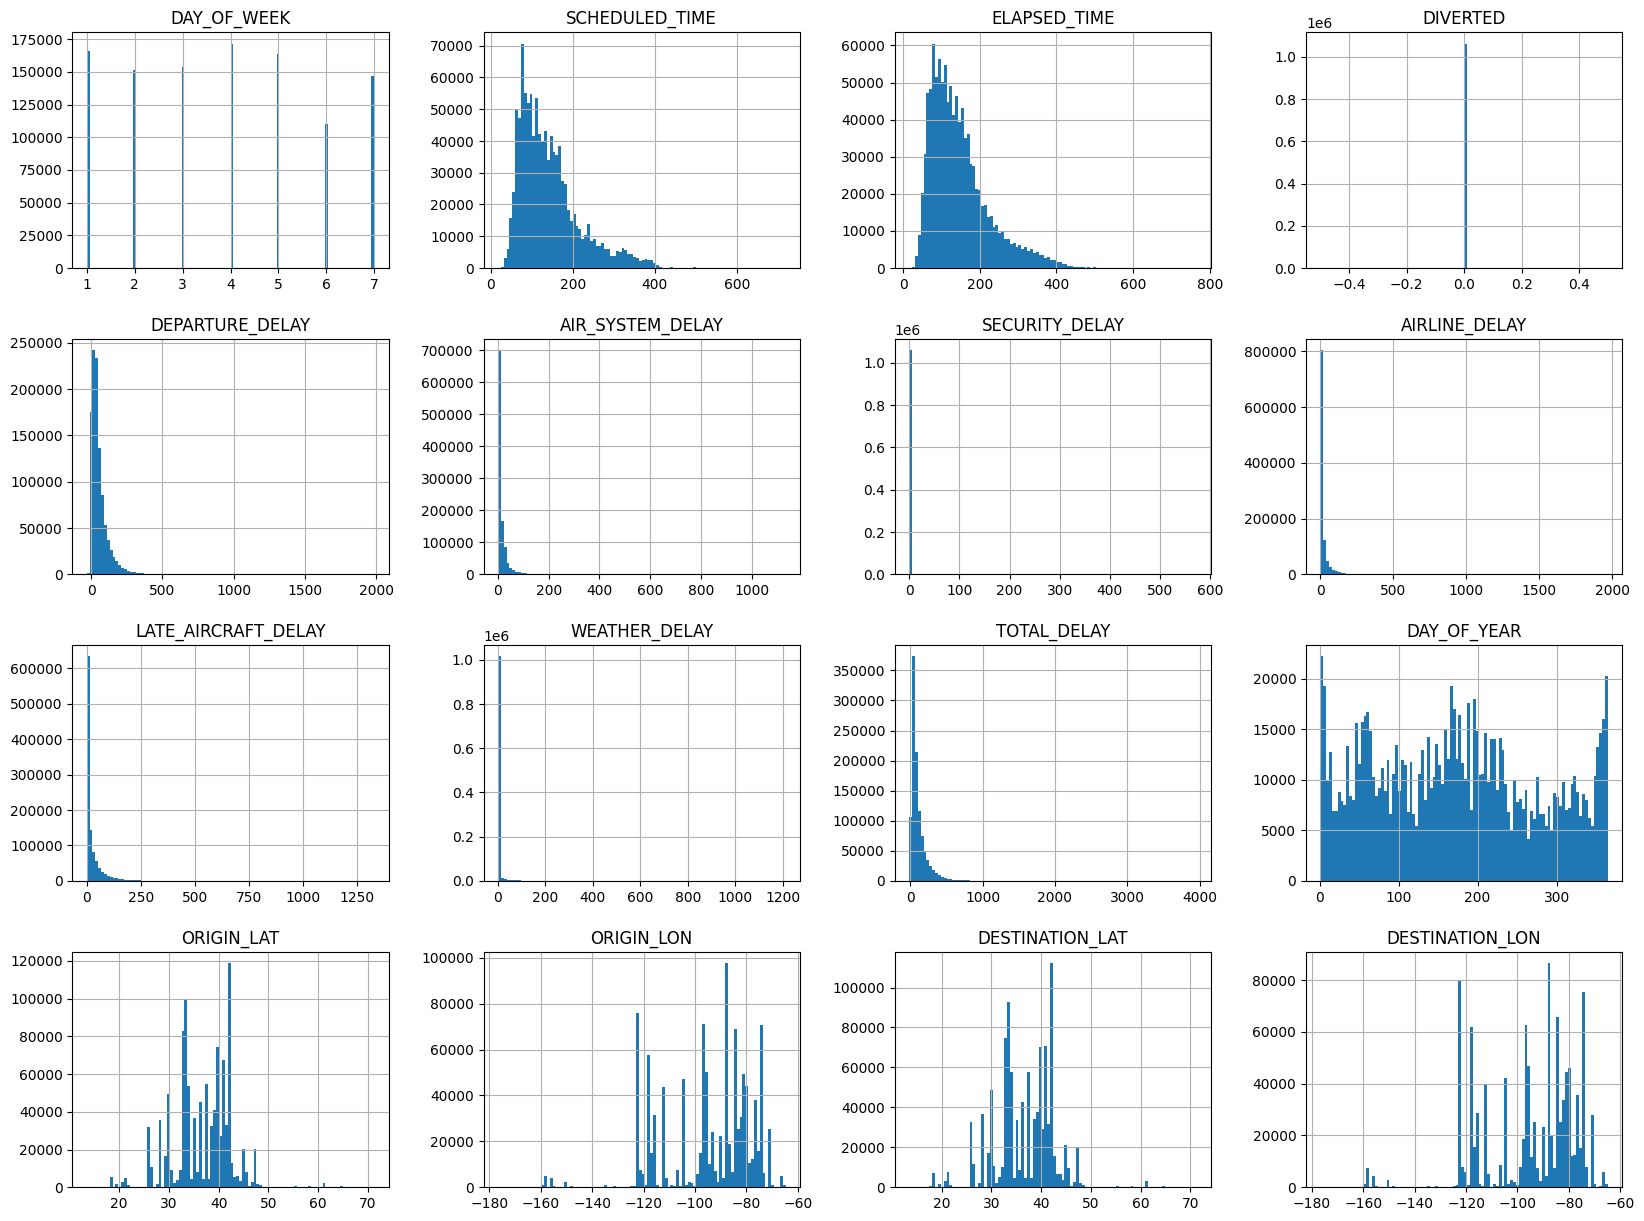

In [16]:
flown_noNA.hist(bins=100, figsize=(20,15))
print(flown_noNA.head())

#### Delay time VS. Airlines

Next, we'll investigate `TOTAL_DELAY` as a function of individual airlines. This is done by simultaneously plotting the total delay time for each airline and sorting the results in descending order by delay length. This will place airlines with the highest delays on the left and airlines with the shortest delays on the right side of the axis. To handle extreme cases (e.g. outliers), we will plot the logarithm of the total delay time, and sort on the log(Delay Time) values.

C:\Users\aaron\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\aaron\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\aaron\AppData\Local\Temp\ipykernel_19904\3816173459.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  delay_plot.set_xticklabels(delay_plot.get_xticklabels(), rotation=45, horizontalalignment='right')


     index  DAY_OF_WEEK                 AIRLINE  SCHEDULED_TIME  ELAPSED_TIME  \
0   337720            5  American Airlines Inc.           134.0         117.0   
1  3412085            6  American Airlines Inc.           185.0         205.0   
2  4103531            7  American Airlines Inc.           179.0         174.0   
3  5810811            4  American Airlines Inc.           104.0          91.0   
4  5279939            5  American Airlines Inc.            82.0          89.0   

   DIVERTED  DEPARTURE_DELAY  AIR_SYSTEM_DELAY  SECURITY_DELAY  AIRLINE_DELAY  \
0         0           1988.0               0.0             0.0         1971.0   
1         0           1878.0              20.0             0.0         1878.0   
2         0           1670.0               0.0             0.0         1665.0   
3         0           1649.0               0.0             0.0         1636.0   
4         0           1631.0               7.0             0.0         1631.0   

   LATE_AIRCRAFT_DELAY  WE

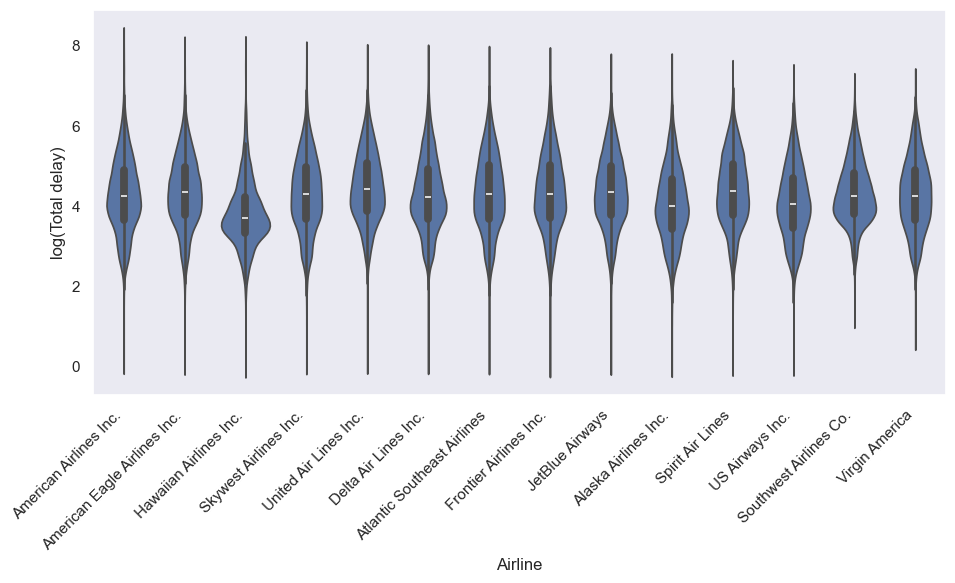

In [17]:
import seaborn as sns

sns.set_theme(style="dark", rc={'figure.figsize':(11,5)})

# Pre-emptively sort dataframe
sorted_delay = flown_noNA.sort_values(by='TOTAL_DELAY',ascending=False).reset_index()
descending_delays = sorted_delay['AIRLINE'].unique()

# Generate plot of delays sorted by decreasing delay
log_delay = np.log(sorted_delay['TOTAL_DELAY'])
delay_plot = sns.violinplot(sorted_delay, x="AIRLINE", y=log_delay, order=descending_delays)
delay_plot.set_xticklabels(delay_plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel("Airline")
plt.ylabel("log(Total delay)")

# Show head of dataframe
print(sorted_delay.head())

### Delay time VS Day of the Week

Similarly, we'll plot log(Total Delay) for each day of the week (`DAY_OF_WEEK`=1 corresponds to Monday).

C:\Users\aaron\AppData\Local\Temp\ipykernel_19904\3211128654.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  delay_plot.set_xticklabels(delay_plot.get_xticklabels(), rotation=45, horizontalalignment='right')


Text(0, 0.5, 'log(Total delay)')

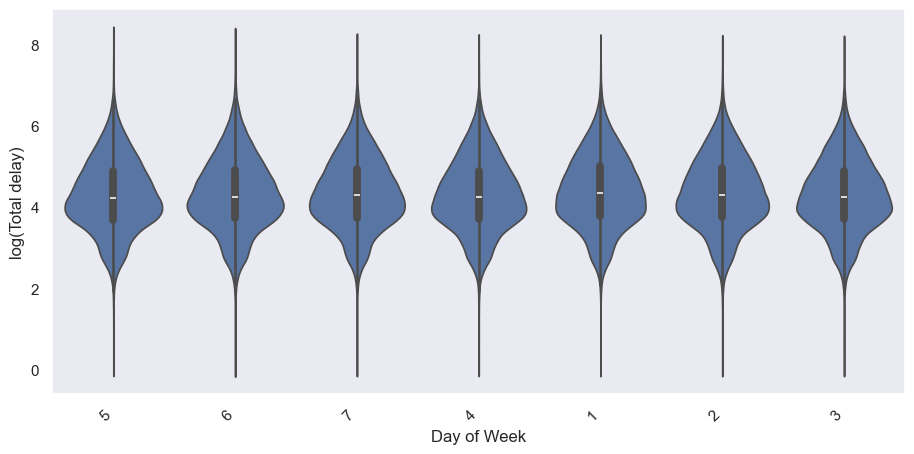

In [18]:
# Pre-emptively sort dataframe
descending_DayOfWeek = sorted_delay['DAY_OF_WEEK'].unique()

# Generate plot of delays sorted by decreasing delay
delay_plot = sns.violinplot(sorted_delay, x="DAY_OF_WEEK", y=log_delay, order=descending_DayOfWeek)
delay_plot.set_xticklabels(delay_plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel("Day of Week")
plt.ylabel("log(Total delay)")

   The resulting plot demonstrates that delays often accumulate the most on Fridays followed by Saturday and Sunday. By comparison, weekday flights are significantly less delayed. Since Friday and the weekends are generally associated with higher volume traffic in aiports, we may be tempted to associate the increase in the number of flights with the increase in delays.
   
   But is this really the case? To associate the number of flights and the total length of flight delays, we'd need to examine the number of flights recorded on each day of the week. In doing so, we would expect that days with longer total flight delays would also have a higher number of flights. To make the plot, we'll use our dataframe's `sum` function. Only this time, we'll keep the plot unsorted so the days of the plot (1, 2, ...) correspond to days as we know them (Monday, Tuesday, etc.)

In [19]:
sorted_delay.head()

,index,DAY_OF_WEEK,AIRLINE,SCHEDULED_TIME,ELAPSED_TIME,DIVERTED,DEPARTURE_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,TOTAL_DELAY,DAY_OF_YEAR,ORIGIN_LAT,ORIGIN_LON,DESTINATION_LAT,DESTINATION_LON,MAX_DELAY
0,337720,5,American Airlines Inc.,134.0,117.0,0,1988.0,0.0,0.0,1971.0,0.0,0.0,3959.0,23,33.56294,-86.75355,32.89595,-97.03720,AIRLINE_DELAY
1,3412085,6,American Airlines Inc.,185.0,205.0,0,1878.0,20.0,0.0,1878.0,0.0,0.0,3776.0,213,37.50517,-77.31967,32.89595,-97.03720,AIRLINE_DELAY
2,4103531,7,American Airlines Inc.,179.0,174.0,0,1670.0,0.0,0.0,1665.0,0.0,0.0,3335.0,256,32.73356,-117.18966,32.89595,-97.03720,AIRLINE_DELAY
3,5810811,4,American Airlines Inc.,104.0,91.0,0,1649.0,0.0,0.0,1636.0,0.0,0.0,3285.0,365,35.04022,-106.60919,32.89595,-97.03720,AIRLINE_DELAY
4,5279939,5,American Airlines Inc.,82.0,89.0,0,1631.0,7.0,0.0,1631.0,0.0,0.0,3269.0,331,42.21206,-83.34884,41.97960,-87.90446,AIRLINE_DELAY


[Text(0, 0, '166266'),
 Text(0, 0, '151183'),
 Text(0, 0, '153604'),
 Text(0, 0, '171692'),
 Text(0, 0, '163441'),
 Text(0, 0, '110315'),
 Text(0, 0, '146938')]

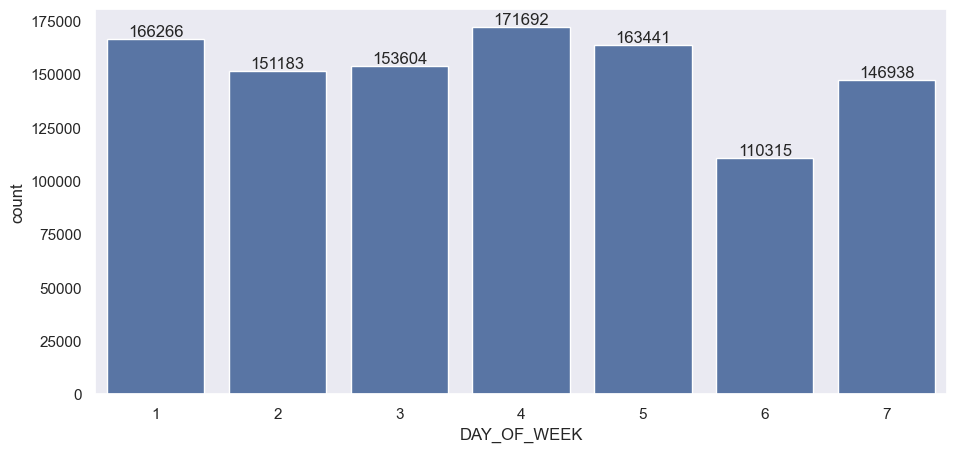

In [20]:
# Count DAY_OF_WEEK occurrences, plot and label
ax = sns.countplot(sorted_delay, x="DAY_OF_WEEK")
ax.bar_label(ax.containers[0])

Interestingly, the largest number of flights within the dataset occurred on Thursday (DoW=4), then Friday (DoW=5), then Monday (DoW=1), but this is not the same order of the first three days in the `TOTAL_DELAY` plot (whose order was Friday, Saturday, then Sunday).

Based on this comparison, we can say that the length of the flight delays is not directly associated with the *number* of flights on a given day, but rather some other factor. Of course, we must keep in mind that these conclusions are reached on a dataset of decreased volume based on the cleaning we performed at the beginning of the analysis.

## Delay cause

   Alternatively, we can query the database directly to find the root cause of the delays. We can use the cleaned dataset to plot the delay type according to the database for the leading offender in flight delays.

   The results illustrate that "Airline" is the leading cause, followed by late aircraft then weather. While not terribly helpful, the plot does show that late flights and weather are amongth the top three causes of flight delays. Nonetheless, questions remain: What is constituted as an "Airline delay"? What causes "late aircraft"? How are weather and late aircraft associated? These are questions that remain outside the scope of this course given our interest in developing an AI/ML approach to data analysis.

C:\Users\aaron\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'American Airlines Inc. delay causes')

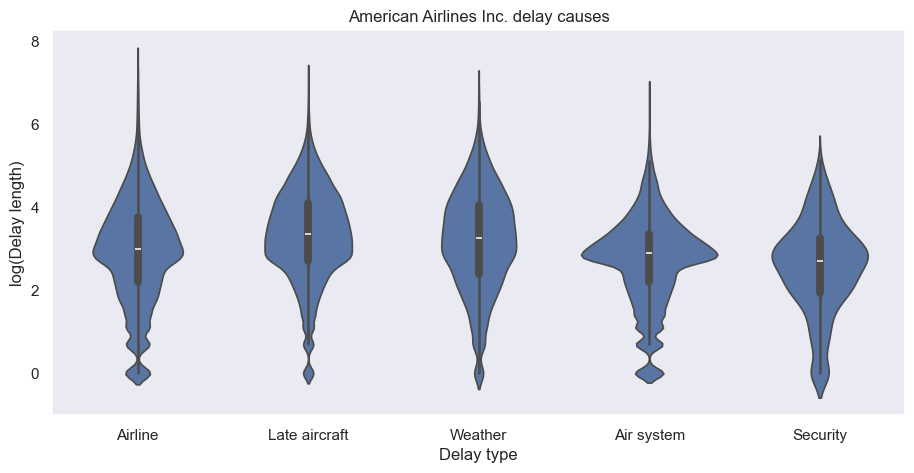

In [21]:
# Generate plot of delay type for most delayed airline
largest_delay_airline = sorted_delay['AIRLINE'][0]
largest_delay_by_airline = sorted_delay[sorted_delay['AIRLINE']==largest_delay_airline]

# Retain only flight delay data
trimmed_df = largest_delay_by_airline[['AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY','TOTAL_DELAY']]
delay_melt = trimmed_df.melt('TOTAL_DELAY', var_name='TYPE', value_name='LENGTH')

# Sort data by delay length
sorted_by_delay_len = delay_melt.sort_values(by='LENGTH',ascending=False).reset_index()
sorted_by_delay_len['TYPE'] = [x.replace('_DELAY','').replace('_',' ').capitalize() for x in sorted_by_delay_len['TYPE']]
descending_Type = sorted_by_delay_len['TYPE'].unique()
sorted_by_delay_len['LENGTH'] = np.log(sorted_by_delay_len['LENGTH'])

# Display violin plot of delay type sorted by decreasing delay length
delay_plot = sns.violinplot(sorted_by_delay_len, x="TYPE", y="LENGTH",order=descending_Type)
plt.xlabel("Delay type")
plt.ylabel("log(Delay length)")
plt.title(largest_delay_airline + " delay causes")

Other detail-oriented analyses could also be done:
- Delay causes across each airline
- Delay length different geographic regions
- Delay cause across different geographic regions
- etc.

# AI/ML Analysis

With a rudimentary understanding of our dataset, we'll begin a basic ML analysis. Specifically, we'll develop a model to categorize the *type* of delay experienced by a flight given the other parameters we've held on to.

### Parameter relationships
Plotting the correlation of each numerical value (`numeric_only=True`) in the dataframe shows us how strongly each variable is related. If we were to plot the correlation right now, we'd notice the `DIVERTED` column contains only one value and therefore has a null correlation and the column needs to be removed. 

Furthermore, there remains a strong correlation between `SCHEDULED_TIME` and `ELAPSED_TIME`. This is because the latter is an estimate of the former, and once the aircraft takes off, there is typically little delay experienced by the aircraft in route. For this analysis, we'll also remove `SCHEDULED_TIME`.

We'll also add a column combining all five `_DELAY` columns and describes the maximum delay experienced for any given flight.

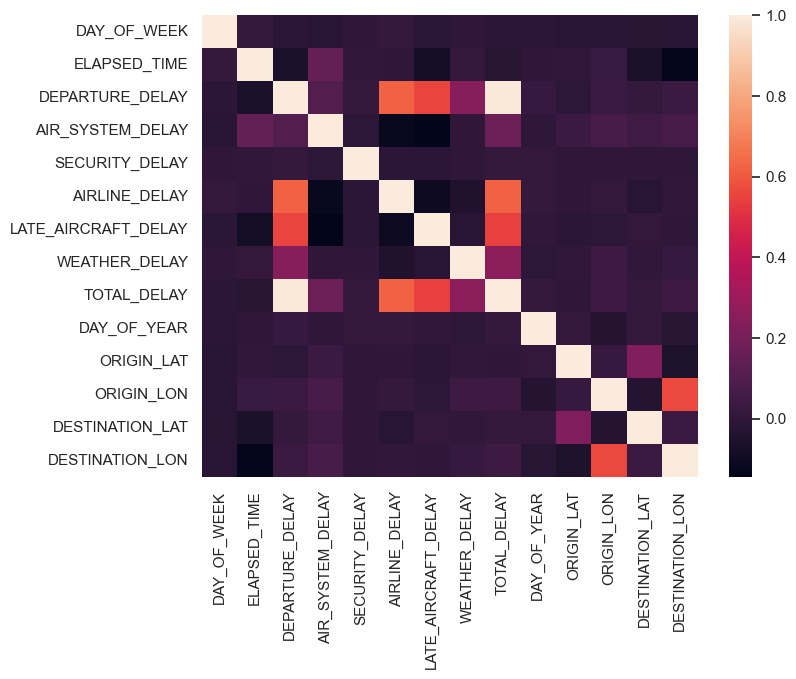

In [22]:
# Remove `DIVERTED`
rm_diverted = sorted_delay.drop(columns=['index','DIVERTED','SCHEDULED_TIME'])

# Plot a graphical correlation matrix for each pair of columns in the dataframe
corr2 = rm_diverted.corr(numeric_only=True)

plt.figure(figsize = (8,6))
sns.heatmap(corr2, annot=False)
sns.set(font_scale=0.7)
plt.show()

In the correlation plot, the only strong correlations are along the diagonal (since each variable is 100% correlated with itself) and `TOTAL_DELAY` and `DEPARTURE_DELAY`. The latter correlation tells us that much of the delay that can happen to an aircraft will likely happen on the ground before the aircraft takes off. This makes sense, so we'll leave both variables in place.

### Convert strings to numerical values

Our next step is to convert remaining strings to numbers, namely the `AIRLINE` names. So we are able to later recall which numerical values correspond to each airline, we'll create a table listing the two side by side, and again printing the dataframe.

In [23]:
# Generate correlation between numerical values and airline names
airlines = rm_diverted['AIRLINE'].unique()
indices = np.arange(len(airlines))
airline_key = zip(airlines,indices)

# Show corresponding values
print(list(airline_key))

# Show result beforehand
print('\nUnique airlines before substitution:\n',rm_diverted['AIRLINE'].unique())

for k in np.arange(len(airlines)):
    rm_diverted.loc[rm_diverted['AIRLINE'] == airlines[k], 'AIRLINE'] = k

# Show result afterward
print('\nUnique airlines after substitution:\n',rm_diverted['AIRLINE'].unique())

print(rm_diverted.head())

[('American Airlines Inc.', 0), ('American Eagle Airlines Inc.', 1), ('Hawaiian Airlines Inc.', 2), ('Skywest Airlines Inc.', 3), ('United Air Lines Inc.', 4), ('Delta Air Lines Inc.', 5), ('Atlantic Southeast Airlines', 6), ('Frontier Airlines Inc.', 7), ('JetBlue Airways', 8), ('Alaska Airlines Inc.', 9), ('Spirit Air Lines', 10), ('US Airways Inc.', 11), ('Southwest Airlines Co.', 12), ('Virgin America', 13)]

Unique airlines before substitution:
 ['American Airlines Inc.' 'American Eagle Airlines Inc.'
 'Hawaiian Airlines Inc.' 'Skywest Airlines Inc.' 'United Air Lines Inc.'
 'Delta Air Lines Inc.' 'Atlantic Southeast Airlines'
 'Frontier Airlines Inc.' 'JetBlue Airways' 'Alaska Airlines Inc.'
 'Spirit Air Lines' 'US Airways Inc.' 'Southwest Airlines Co.'
 'Virgin America']

Unique airlines after substitution:
 [0 1 2 3 4 5 6 7 8 9 10 11 12 13]
   DAY_OF_WEEK AIRLINE  ELAPSED_TIME  DEPARTURE_DELAY  AIR_SYSTEM_DELAY  \
0            5       0         117.0           1988.0           

And we'll do the same for the column identifying the maximum delay type for each flight.

In [24]:
# Generate correlation between numerical values and airline names
delays = rm_diverted['MAX_DELAY'].unique()
indices = np.arange(len(delays))
delay_key = zip(delays,indices)

# Create unique labels for ML characterization
uniqlbl = [x.split('_')[0] for x in rm_diverted['MAX_DELAY'].unique()]

for k in np.arange(len(delays)):
    rm_diverted.loc[rm_diverted['MAX_DELAY'] == delays[k], 'MAX_DELAY'] = k

# Remove any final NaN values from dataframe
clean_noNA = rm_diverted.dropna()

print("\nFinal dataset size:\n",clean_noNA.shape)
print('\nNaN values in final array:\n',clean_noNA.isnull().values.any(),'\n')


Final dataset size:
 (1061932, 16)

NaN values in final array:
 False 



### Split dataset into train and test sets

Now, our dataset only contains numerical values. We then split the dataset into training data and test data, at a ratio of 80:20. Of the split data, we need to resacle input parameters ("features") so that all features contribute equally to the model -- a process known as "feature scaling". Finally, the categorical columns are converted into numerical columns for the ML model.

In [25]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn import utils

# Remove most significant arrays; `y` and `feature_list` do not change
clean_delays = clean_noNA.drop(columns=['DEPARTURE_DELAY','AIR_SYSTEM_DELAY','SECURITY_DELAY','WEATHER_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY'])

X = clean_delays.drop(columns=['MAX_DELAY']).values
y = clean_delays['MAX_DELAY'].values
feature_list = list(clean_delays.drop(columns=['MAX_DELAY']).columns)

# Re-split the data into training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert categorical columns into numerical columns for fitting
lab = preprocessing.LabelEncoder()
y_train = lab.fit_transform(y_train)
y_test = lab.fit_transform(y_test)

C:\Users\aaron\AppData\Local\Temp\ipykernel_19904\2877307028.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log = pd.concat([log, log_entry], ignore_index=True)
C:\Users\aaron\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


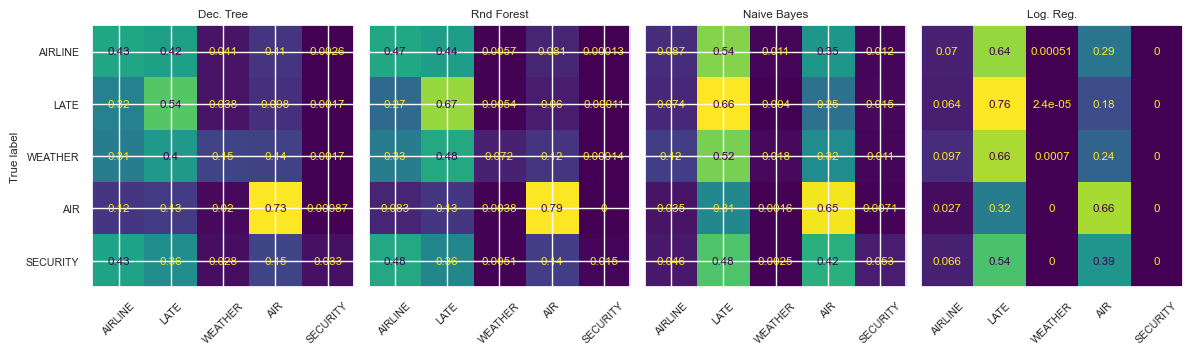

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, log_loss

# --------- PLOT TOP ROW OF CLASSIFIERS ---------
classifiers = {
    "Dec. Tree": DecisionTreeClassifier(),
    "Rnd Forest": RandomForestClassifier(n_estimators = 25, criterion = 'gini'),
    "Naive Bayes": GaussianNB(),
    "Log. Reg.": LogisticRegression(),
}

f, axes = plt.subplots(1, 4, figsize=(12,6), sharey='row')

log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred, normalize='true')

    name = key
    train_predictions = classifier.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    train_predictions = classifier.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = pd.concat([log, log_entry], ignore_index=True)
    
    disp = ConfusionMatrixDisplay(cf_matrix,
                                  display_labels=uniqlbl,
                                 )
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

plt.rcParams["axes.grid"] = False
plt.style.use('dark_background')
sns.set_color_codes("muted")
plt.grid(False)
plt.tight_layout()
plt.show()

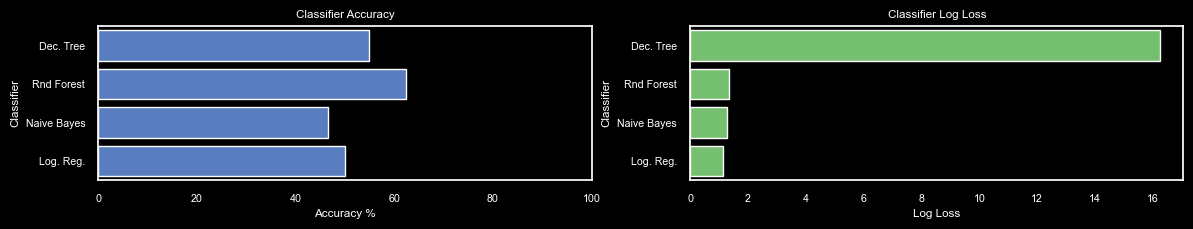

In [27]:
# Image bar charts for Accuracy and Log Loss
import seaborn as sns
plt.figure(figsize=(14,2))
plt.subplot(1,2,1)
plt.style.use('dark_background')
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
plt.xlabel('Accuracy %')
plt.xlim(0,100)
plt.title('Classifier Accuracy')

plt.subplot(1,2,2)
sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")
plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

In [28]:
for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    r2_reg_model_test = round(classifier.score(X_test, y_test),2)
    print(classifier,"R^2 Value: {}".format(r2_reg_model_test))

DecisionTreeClassifier() R^2 Value: 0.55
RandomForestClassifier(n_estimators=25) R^2 Value: 0.63
GaussianNB() R^2 Value: 0.47
LogisticRegression() R^2 Value: 0.5


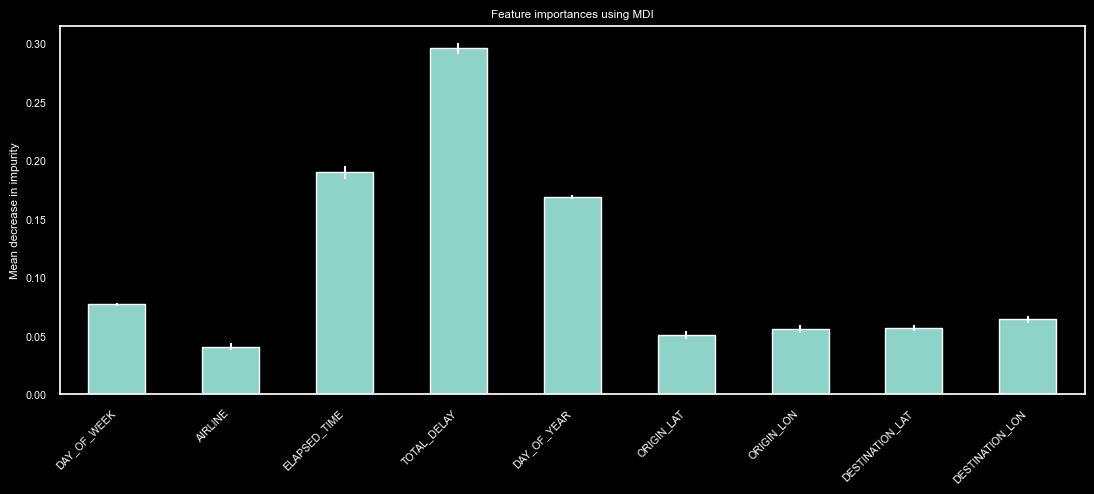

In [29]:
# Create a  regressor using all the feature variables
rf_model = RandomForestClassifier(n_estimators=25, criterion='gini')
rf_model.fit(X_train, y_train)

feature_names = [f"feature {i}" for i in range(X.shape[1])]
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_list)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [31]:
rf_model = RandomForestClassifier(n_estimators=30, min_samples_split=12, min_samples_leaf=2,max_features='sqrt')
rf_model.fit(X_train, y_train)
r2_reg_model_test = round(rf_model.score(X_test, y_test),2)
print(maxfeat, ": ", r2_reg_model_test)

None :  0.64


The RandomForest classifier contains 19 hyperparameters; some directly effect the model's outcome (ex. `n_estimators`, `max_depth`, etc.), others do not (ex. `verbose`, `random_state`, etc.)

Although not shown, each of the following hyperparameters were manually optimized:
- `n_estimators` = 30
- `min_samples_split` = 12
- `min_samples_leaf` = 2
- `max_features` = 'sqrt'
  
Unfortunately, our maximum accuracy is ~64% and that will have to be good enough for now. We've tried different classifier models, but we've yet to exhaust the entire list of classifiers we could use. We could use better data, but we chose this database based on it's broken, semi-functional nature to illustrate how different datasaets could be woven together.